# Identifying fraud from Enron e-mails

## Table of Contents
* <a href="#sec1">1. Introduction</a>
  * <a href="#sec1.1"> 1.1. Initial statements </a>

* <a href="#sec2">2. Data Wrangling</a>
  * <a href="#sec2.1"> 2.1. Loading the data </a>

* <a href="#sec3">3. Feature selection</a>
  * <a href="#sec3.1"> 3.1. Selecting valid data </a>
  * <a href="#sec3.2"> 3.2. Looking for outliers </a>

<a id='sec1'></a>
## 1. Introduction

<a id='sec1.1'></a>
### 1.1. Initial statements
This section sets up import statements for all the packages that will be used throughout this python notebook.

In [3]:
# Udacity statements
import sys
import pickle
sys.path.append("tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

# Data analysis packages:
import pandas as pd
import numpy as np
#from datetime import datetime as dt

# Visualization packages:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
## Forcing pandas to display any number of elements
pd.set_option('display.max_columns', None)
pd.options.display.max_seq_items = 2000

<a id='sec2'></a>
## 2. Data wrangling
Analyzing the data integrity, the expected values and removing outliers.

<a id='sec2.1'></a>
### 2.1. Loading the data

In [5]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [6]:
## What is the data type and length?
print('Dataset type: ',type(data_dict))
print('Dataset length: ',len(data_dict))

('Dataset type: ', <type 'dict'>)
('Dataset length: ', 146)


In [7]:
## Exploring the dataset through pandas.Dataframe
dataset = pd.DataFrame.from_dict(data_dict, orient='index')
dataset.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,13868,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,3486,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,56301,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,11200,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,129142,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN


<a id='sec2.2'></a>
### 2.2 Analyzing string data:

In [8]:
dataset.describe()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
count,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146
unique,95,87,40,126,102,42,98,84,19,125,95,5,65,93,42,2,18,45,53,112,58
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
freq,51,60,107,21,44,64,36,60,128,20,51,142,60,53,60,128,129,97,80,35,60


In [9]:
## Checking the feature data type:
features_to_check = []
for col in dataset.columns:
    datatype = type(dataset[col][0])
    ## Uncomment the line below for a verbose mode:
    # print '{} has type {}'.format(col,datatype)
    ## Here we select those attributes which have string type data:
    if datatype is str:
        features_to_check.append(col)

In [10]:
## Printing out the features that must be checked (string types are not iterable!)
features_to_check

['loan_advances', 'director_fees', 'email_address']

From the features above, only *email_address* is expected to contain string type data. In this way, an in-depth look must be done in the other ones.

<a id='sec2.2.1'></a>
#### 2.2.1 Checking *loan_advances* data:
This attribute type is originally *(str type)*. However, it was expected to have financial values. 

In [11]:
dataset['loan_advances'].unique()

array(['NaN', 2000000, 81525000, 400000, 83925000], dtype=object)

Only four instances have *loan_advances* valid values. Checking them out:

In [12]:
dataset[dataset['loan_advances']!='NaN']

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
FREVERT MARK A,1060932,3275,6426990,17252530,10433518,2000000,4188667,2979,NaN,14622185,86987,2000000,21,7427621,6,False,NaN,-3367011,1617011,mark.frevert@enron.com,242
LAY KENNETH L,1072321,4273,202911,103559793,34348384,7000000,14761694,2411,NaN,49110078,99832,81525000,36,10359729,16,True,NaN,-300000,3600000,kenneth.lay@enron.com,123
PICKERING MARK R,655037,898,NaN,1386690,28798,300000,NaN,728,NaN,28798,31653,400000,67,NaN,0,False,NaN,NaN,NaN,mark.pickering@enron.com,7
TOTAL,26704229,NaN,32083396,309886585,311764000,97343619,130322299,NaN,-7576788,434509511,5235198,83925000,NaN,42667589,NaN,False,1398517,-27992891,48521928,NaN,NaN


The first outlier pops out from this data -- the **TOTAL** instance must be removed. Besides it, this feature occurs only for three valid instances, in the way maybe it's not the best feature to feed our classifier.

<a id='sec2.2.2'></a>
#### 2.2.1 Checking *director_fees* data:
As for *loan_advances*, this attribute type is originally *(str type)*. However, it was expected to have financial values too. 

In [13]:
dataset['director_fees'].unique()

array(['NaN', 3285, 137864, 113784, 98784, 102492, 119292, 108750, 112492,
       103750, 38346, 101250, 17500, 125034, 1398517, 36666, 109298, 108579], dtype=object)

In [14]:
dataset[dataset['director_fees']!='NaN']

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
BELFER ROBERT,NaN,NaN,-102500,102500,3285,NaN,NaN,NaN,44093,-44093,NaN,NaN,NaN,NaN,NaN,False,3285,NaN,NaN,NaN,NaN
BHATNAGAR SANJAY,NaN,523,NaN,15456290,2604490,NaN,-2604490,463,15456290,NaN,NaN,NaN,29,137864,1,False,137864,NaN,NaN,sanjay.bhatnagar@enron.com,0
BLAKE JR. NORMAN P,NaN,NaN,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN,1279,NaN,NaN,NaN,NaN,False,113784,-113784,NaN,NaN,NaN
CHAN RONNIE,NaN,NaN,NaN,NaN,NaN,NaN,32460,NaN,-32460,NaN,NaN,NaN,NaN,NaN,NaN,False,98784,-98784,NaN,NaN,NaN
DUNCAN JOHN H,NaN,NaN,NaN,77492,371750,NaN,NaN,NaN,NaN,371750,NaN,NaN,NaN,NaN,NaN,False,102492,-25000,NaN,NaN,NaN
GRAMM WENDY L,NaN,NaN,NaN,119292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,119292,NaN,NaN,NaN,NaN
JAEDICKE ROBERT,NaN,NaN,NaN,83750,431750,NaN,44093,NaN,-44093,431750,NaN,NaN,NaN,NaN,NaN,False,108750,-25000,NaN,NaN,NaN
LEMAISTRE CHARLES,NaN,NaN,NaN,87492,412878,NaN,NaN,NaN,NaN,412878,NaN,NaN,NaN,NaN,NaN,False,112492,-25000,NaN,NaN,NaN
MENDELSOHN JOHN,NaN,NaN,NaN,148,NaN,NaN,NaN,NaN,NaN,NaN,148,NaN,NaN,NaN,NaN,False,103750,-103750,NaN,NaN,NaN
MEYER JEROME J,NaN,NaN,NaN,2151,NaN,NaN,NaN,NaN,NaN,NaN,2151,NaN,NaN,NaN,NaN,False,38346,-38346,NaN,NaN,NaN


Regarding the ***director_fees*** feature, only 17 instances contains valid value. What calls attention in this case is that most of the other features has **NaN** values, which brings suspection that maybe they refers to false names. Surely something that must be checked later. 

<a id='sec2.3'></a>
### 2.3 Converting string "NaN" to numpy.NaN
From the previous output, it was clear there are some 'NaN' in string type instead of numerical or numpy type, which causes some troubles when plotting data or using some classifier. Due to this, the next step is to scan the dataset for 'NaN' string and replace it by numpy.NaN.

In [15]:
for column in dataset.columns:
    dataset[column] = dataset[column].apply(lambda x: np.NaN if x == 'NaN' else x)

In [16]:
## Checking the dataset information:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       95 non-null float64
to_messages                  86 non-null float64
deferral_payments            39 non-null float64
total_payments               125 non-null float64
exercised_stock_options      102 non-null float64
bonus                        82 non-null float64
restricted_stock             110 non-null float64
shared_receipt_with_poi      86 non-null float64
restricted_stock_deferred    18 non-null float64
total_stock_value            126 non-null float64
expenses                     95 non-null float64
loan_advances                4 non-null float64
from_messages                86 non-null float64
other                        93 non-null float64
from_this_person_to_poi      86 non-null float64
poi                          146 non-null bool
director_fees                17 non-null float64
deferred_income              49 non-null float

<a id='sec2.4'></a>
### 2.4 Counting valid data
As seen before, there are many null data in our dataset. In order to select the most appropriate features to explore, we will look for those that are present at least in 70% of the dataset. Considering there are 21 features (from which 70% is approximate to 15 features), we will first observe which instances have more than 15 not null values and choose the most complete features from this selection.

In [17]:
notNullDataset = dataset.dropna(thresh=15)

In [18]:
notNullDataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58 entries, ALLEN PHILLIP K to WHALLEY LAWRENCE G
Data columns (total 21 columns):
salary                       58 non-null float64
to_messages                  57 non-null float64
deferral_payments            16 non-null float64
total_payments               58 non-null float64
exercised_stock_options      51 non-null float64
bonus                        54 non-null float64
restricted_stock             57 non-null float64
shared_receipt_with_poi      57 non-null float64
restricted_stock_deferred    7 non-null float64
total_stock_value            57 non-null float64
expenses                     52 non-null float64
loan_advances                3 non-null float64
from_messages                57 non-null float64
other                        58 non-null float64
from_this_person_to_poi      57 non-null float64
poi                          58 non-null bool
director_fees                1 non-null float64
deferred_income              26 non-null floa

From the output above, the features named *deferral_payments; restricted_stock_deferred;* and *director_fees* are removed. Doing so the pre-selected features list can be defined accordingly to its context:

In [48]:
## Only numerical features are being considered here
financialFeatures = ['salary','bonus', 'exercised_stock_options', 'restricted_stock', 'shared_receipt_with_poi',
                     'total_payments', 'expenses', 'total_stock_value', 'deferred_income', 'long_term_incentive']
behavioralFeatures = ['to_messages', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'other']
allFeatures = ['salary','bonus', 'exercised_stock_options', 'restricted_stock', 'shared_receipt_with_poi',
               'total_payments', 'expenses', 'total_stock_value', 'deferred_income', 'long_term_incentive',
               'to_messages', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'other']

Since in the *feature_format()* method the "NaN" strings are replaced by zeros, we need to make this adjustment here.

In [20]:
dataset.fillna(0,inplace=True)

<a id='sec2.5'></a>
### 2.5 Outlier removal
In this section we look for identifying and, if it is the case, removing outliers in our dataset.

<a id='sec2.5.1'></a>
### 2.5.1 Visualizing data by features
The objective here is to visualize how the data is distributed accordingly to each feature, as well as identifying outliers through visual inspection. For this we make use of a function build based on the code available in (http://stamfordresearch.com/outlier-removal-in-python-using-iqr-rule/)

In [21]:
def visualizeFeat(series, figsize):
    ''' series = pandas.series, which can be inputed as "dataframe['feature']
        figsize = (width,length)'''
    fig, axes = plt.subplots(2,1,figsize=figsize, sharex=True)
    series.plot(kind='kde', ax=axes[0])
    sns.boxplot(x=series, ax=axes[1])
    plt.xlim(series.min(), series.max()*1.1)
    return

The function above seems useful to get information for only one variable. Since we want to explore the whole dataset (or at least a good chunk of it), we will code a function to show them all:

In [22]:
def visualize3Feats(dataset, features):
    '''Shows the distribution and the boxplot for the given features of a pandas.Dataframe:
        dataset = pandas dataframe.
        features = list of features of interest'''
    ## Building the Figure:
    fig, axes = plt.subplots(2,3,figsize=(15,6), sharex=False)
    for col, feat in enumerate(features):
        dataset[feat].plot(kind='kde', ax=axes[0,col])
        sns.boxplot(x=dataset[feat], ax=axes[1,col])
        axes[0,col].set_xlim(dataset[feat].min(), dataset[feat].max()*1.1);
        axes[1,col].set_xlim(dataset[feat].min(), dataset[feat].max()*1.1);
    return

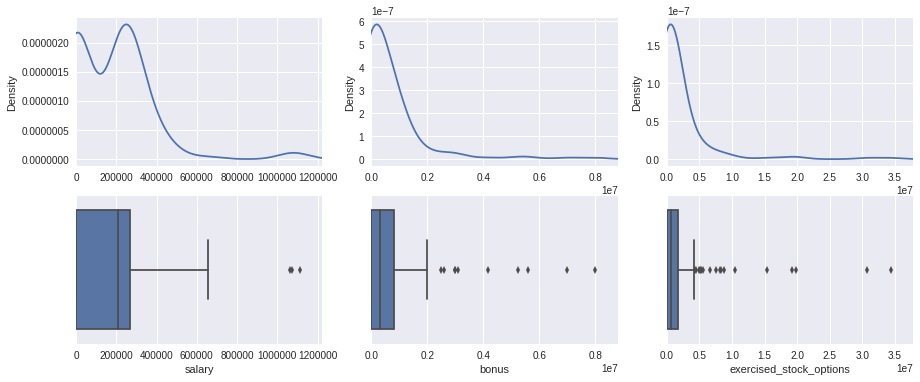

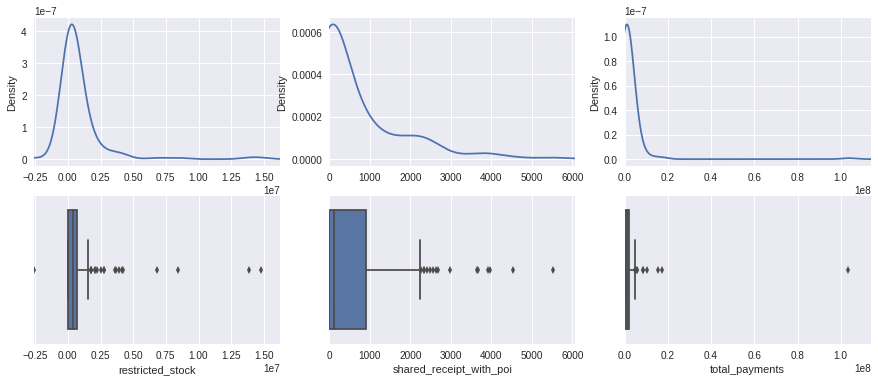

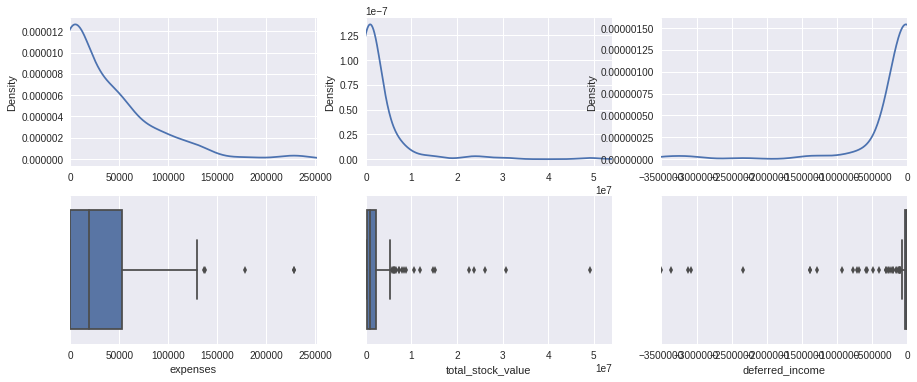

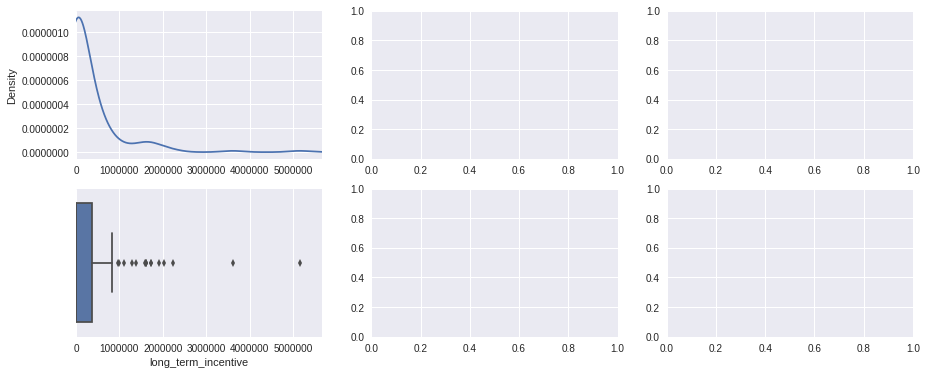

In [25]:
### Visualizing financial features:
numPlots = int(np.ceil(len(financialFeatures)/3.))
for i in range(numPlots):
    shift = i*3
    visualize3Feats(dataset,financialFeatures[0+shift:3+shift])

From the charts above, it becomes evident there is at least one strong outlier sample (which in fact was identified during the lesson as the TOTAL instance). Even after removing it (see Section 2.4.2) there are still remaining outliers. However, since they are probably related to what we are looking for, they won't be removed.

<a id='sec2.5.2'></a>
### 2.5.2 Removing **TOTAL** instance
As observed before, the "TOTAL" instance must be removed, since we are interested only on POIs.

In [24]:
dataset.drop('TOTAL',inplace=True)  #Removing the anomalous instance

<a id='sec2.6'></a>
### 2.6 Checking the class distribution

In [26]:
## Counting gender classes
dataset['poi'].value_counts()

False    127
True      18
Name: poi, dtype: int64

<a id='sec2.7'></a>
### 2.7 Stratified data split
Besides we can extract features from the whole dataset, when we are training machine learning algorithms is really important to split the data into training and testing subsets, in order to avoid overfitting. But as seen above, our data is unbalanced and so it is important to split data in a stratified way, i.e., each subset must have the same proportion of each class.

In [27]:
from sklearn.cross_validation import train_test_split

In [28]:
## For pandas.Dataframe the train_test_split is given in a straight way:
trainData, testData = train_test_split(dataset, test_size=0.3, random_state=42, stratify=dataset['poi'])

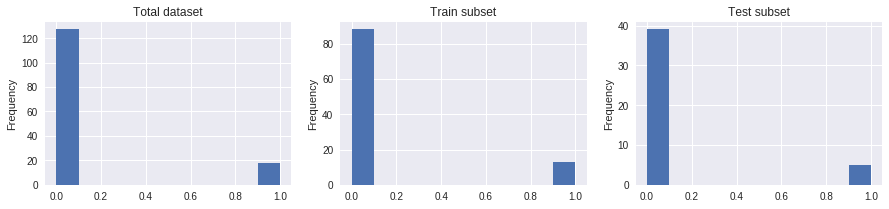

In [29]:
## Evaluating the class distribution:
fig2, axes2 = plt.subplots(1,3,figsize=(15,3), sharex=False);
dataset['poi'].plot(kind='hist', ax=axes2[0], title='Total dataset');
trainData['poi'].plot(kind='hist', ax=axes2[1], title='Train subset');
testData['poi'].plot(kind='hist', ax=axes2[2], title='Test subset');

In [30]:
trainData

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
BERBERIAN DAVID,216582.0,0.0,0.0,228474.0,1624396.0,0.0,869220.0,0.0,0.0,2493616.0,11892.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,david.berberian@enron.com,0.0
KOENIG MARK E,309946.0,2374.0,0.0,1587421.0,671737.0,700000.0,1248318.0,2271.0,0.0,1920055.0,127017.0,0.0,61.0,150458.0,15.0,True,0.0,0.0,300000.0,mark.koenig@enron.com,53.0
WHALEY DAVID A,0.0,0.0,0.0,0.0,98718.0,0.0,0.0,0.0,0.0,98718.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0,0.0
KAMINSKI WINCENTY J,275101.0,4607.0,0.0,1086821.0,850010.0,400000.0,126027.0,583.0,0.0,976037.0,83585.0,0.0,14368.0,4669.0,171.0,False,0.0,0.0,323466.0,vince.kaminski@enron.com,41.0
METTS MARK,365788.0,807.0,0.0,1061827.0,0.0,600000.0,585062.0,702.0,0.0,585062.0,94299.0,0.0,29.0,1740.0,1.0,False,0.0,0.0,0.0,mark.metts@enron.com,38.0
BELFER ROBERT,0.0,0.0,-102500.0,102500.0,3285.0,0.0,0.0,0.0,44093.0,-44093.0,0.0,0.0,0.0,0.0,0.0,False,3285.0,0.0,0.0,0,0.0
MORDAUNT KRISTINA M,267093.0,0.0,0.0,628522.0,0.0,325000.0,208510.0,0.0,0.0,208510.0,35018.0,0.0,0.0,1411.0,0.0,False,0.0,0.0,0.0,kristina.mordaunt@enron.com,0.0
HIRKO JOSEPH,0.0,0.0,10259.0,91093.0,30766064.0,0.0,0.0,0.0,0.0,30766064.0,77978.0,0.0,0.0,2856.0,0.0,True,0.0,0.0,0.0,joe.hirko@enron.com,0.0
GOLD JOSEPH,272880.0,0.0,0.0,2146973.0,436515.0,750000.0,441096.0,0.0,0.0,877611.0,0.0,0.0,0.0,819288.0,0.0,False,0.0,0.0,304805.0,joe.gold@enron.com,0.0
PIRO JIM,0.0,58.0,0.0,0.0,0.0,0.0,47304.0,3.0,0.0,47304.0,0.0,0.0,16.0,0.0,1.0,False,0.0,0.0,0.0,jim.piro@enron.com,0.0


<a id='sec3'></a>
## 3. Feature extraction
From now on we will start applying all the algorithms in the train data. Once we have defined which one we will be using, we then apply to the test data. 

<a id='sec3.1'></a>
### 3.1 Verifying correlation among features
Considering feature extraction, high correlated variables usually are useless for machine learning classification. In this case, it's better to use uncorrelated variables as features, in the way they are orthogonal to each other and so brings on different information aspects from data.  

To check which features are correlated or not we will then use a method from pandas library (http://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.DataFrame.corr.html) and show it through a heatmap to make easier the visualization, as follow:

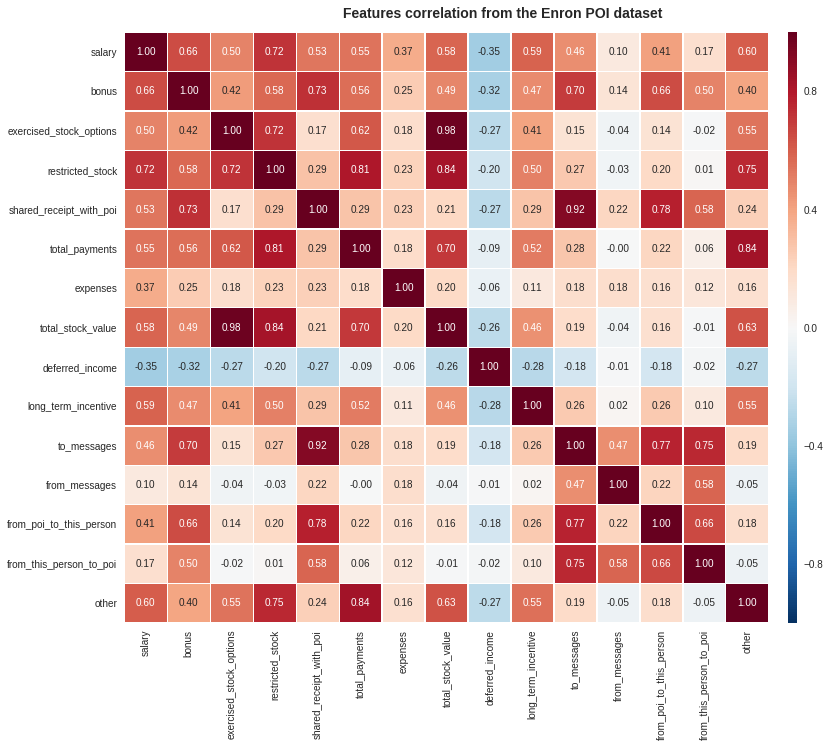

In [31]:
## Calculating the correlation among features by Pearson method
correlationDataframe = trainData[allFeatures].corr()

# Drawing a heatmap with the numeric values in each cell
fig1, ax = plt.subplots(figsize=(14,10))
fig1.subplots_adjust(top=.945)
plt.suptitle('Features correlation from the Enron POI dataset', fontsize=14, fontweight='bold')

cbar_kws = {'orientation':"vertical", 'pad':0.025, 'aspect':70}
sns.heatmap(correlationDataframe, annot=True, fmt='.2f', linewidths=.3, ax=ax, cbar_kws=cbar_kws);

<a id='sec3.2'></a>
### 3.2 Applying PCA on correlated features to generate a new one
Since the financial features are highly correlated, as seen above, we will now apply PCA to generate an only one new feature from them. 

In [32]:
from sklearn.decomposition import PCA

In [33]:
## Listing the financial features
financialFeatures

['salary',
 'bonus',
 'exercised_stock_options',
 'restricted_stock',
 'shared_receipt_with_poi',
 'total_payments',
 'expenses',
 'total_stock_value',
 'deferred_income',
 'long_term_incentive']

In [34]:
## Defining only one resulting component:
pca = PCA(n_components=1)
pca.fit(trainData[financialFeatures])

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [35]:
pcaComponents = pca.fit_transform(trainData[financialFeatures])

In [39]:
trainData.shape

(101, 21)

In [36]:
trainData

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
BERBERIAN DAVID,216582.0,0.0,0.0,228474.0,1624396.0,0.0,869220.0,0.0,0.0,2493616.0,11892.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,david.berberian@enron.com,0.0
KOENIG MARK E,309946.0,2374.0,0.0,1587421.0,671737.0,700000.0,1248318.0,2271.0,0.0,1920055.0,127017.0,0.0,61.0,150458.0,15.0,True,0.0,0.0,300000.0,mark.koenig@enron.com,53.0
WHALEY DAVID A,0.0,0.0,0.0,0.0,98718.0,0.0,0.0,0.0,0.0,98718.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0,0.0
KAMINSKI WINCENTY J,275101.0,4607.0,0.0,1086821.0,850010.0,400000.0,126027.0,583.0,0.0,976037.0,83585.0,0.0,14368.0,4669.0,171.0,False,0.0,0.0,323466.0,vince.kaminski@enron.com,41.0
METTS MARK,365788.0,807.0,0.0,1061827.0,0.0,600000.0,585062.0,702.0,0.0,585062.0,94299.0,0.0,29.0,1740.0,1.0,False,0.0,0.0,0.0,mark.metts@enron.com,38.0
BELFER ROBERT,0.0,0.0,-102500.0,102500.0,3285.0,0.0,0.0,0.0,44093.0,-44093.0,0.0,0.0,0.0,0.0,0.0,False,3285.0,0.0,0.0,0,0.0
MORDAUNT KRISTINA M,267093.0,0.0,0.0,628522.0,0.0,325000.0,208510.0,0.0,0.0,208510.0,35018.0,0.0,0.0,1411.0,0.0,False,0.0,0.0,0.0,kristina.mordaunt@enron.com,0.0
HIRKO JOSEPH,0.0,0.0,10259.0,91093.0,30766064.0,0.0,0.0,0.0,0.0,30766064.0,77978.0,0.0,0.0,2856.0,0.0,True,0.0,0.0,0.0,joe.hirko@enron.com,0.0
GOLD JOSEPH,272880.0,0.0,0.0,2146973.0,436515.0,750000.0,441096.0,0.0,0.0,877611.0,0.0,0.0,0.0,819288.0,0.0,False,0.0,0.0,304805.0,joe.gold@enron.com,0.0
PIRO JIM,0.0,58.0,0.0,0.0,0.0,0.0,47304.0,3.0,0.0,47304.0,0.0,0.0,16.0,0.0,1.0,False,0.0,0.0,0.0,jim.piro@enron.com,0.0


In [40]:
#teste = pd.DataFrame(pcaComponents, columns=['PC1','PC2'], index=dataset.index)
trainData['financial'] = pcaComponents

/home/tbnsilveira/anaconda3/envs/analytics2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


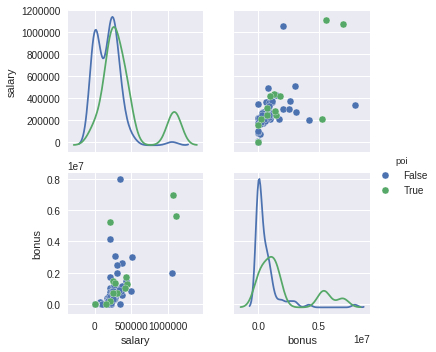

In [41]:
sns.pairplot(trainData,hue='poi',vars=['salary','bonus'], diag_kind='kde')

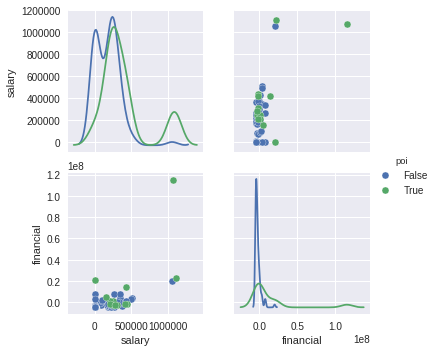

In [42]:
sns.pairplot(trainData,hue='poi',vars=['salary','financial'], diag_kind='kde')

<a id='sec3.3'></a>
### 3.3 Univariate feature selection

In [49]:
## Adding up the new 'financial' feature to the 'allFeatures' list:
allFeatures.append('financial')

In [50]:
allFeatures

['salary',
 'bonus',
 'exercised_stock_options',
 'restricted_stock',
 'shared_receipt_with_poi',
 'total_payments',
 'expenses',
 'total_stock_value',
 'deferred_income',
 'long_term_incentive',
 'to_messages',
 'from_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'other',
 'financial']

First of all, even though the pre-selected features contains many valid data, all the dataset instances have at least one feature or attribute with an invalid value (NaN), which may break many of the algorithms we want to run with. In this case, we will apply the code suggested in (https://stackoverflow.com/questions/30317119/classifiers-in-scikit-learn-that-handle-nan-null) to replace the NaN values for the dataset mean. 

Considering the financial data have some important outliers, mainly related to some POI, it is important to use a different strategy for NaN replacing than the *mean*, which will be the *median* in this case. 

In [52]:
from sklearn.preprocessing import Imputer

# Create our imputer to replace missing values with the mean e.g.
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
imp = imp.fit(trainData[financialFeatures])

imputerData = imp.transform(trainData[financialFeatures])
financialDataset = pd.DataFrame(imputerData, index=trainData.index, columns=financialFeatures)

In [ ]:
financialDataset = dataset[allFeatures]
## Checking the consistency of the new dataset:
financialDataset.info()

The code below is based on the example available in http://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py, in which an univariate feature selection is applied. 

In [ ]:
from sklearn.feature_selection import SelectPercentile, f_classif

selectorDataset = financialDataset
selectorLabel = dataset['poi']

# #############################################################################
# Univariate feature selection with F-test for feature scoring
# We use the default selection function: the 5% most significant features
selector = SelectPercentile(f_classif, percentile=5)
selector.fit(selectorDataset, selectorLabel)

In [ ]:
## Plotting the features selection: 
X_indices = np.arange(selectorDataset.shape[-1])
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(X_indices, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
        edgecolor='black')

In [ ]:
len(scores)

In [ ]:
## Printing out the selected financial features: 
for ix, pval in enumerate(scores):
    print financialFeatures[ix],': ',pval
    #if pval > 0.145:
        #print financialFeatures[ix],': ',pval

In [ ]:
features_selected = ['poi','salary','bonus','exercised_stock_options','total_stock_value',
                 'deferred_income','long_term_incentive']
## 'poi' must be the first one due to the evaluation methods defined by Udacity.

In [ ]:
features_selected = ['poi','financial','exercised_stock_options','total_stock_value',
                 'deferred_income','long_term_incentive']

## Machine Learning

In [ ]:
my_dataset = dataset.to_dict(orient='index')
features_list = features_selected
#features_list = ['poi','salary','bonus','exercised_stock_options','total_stock_value',
#                 'deferred_income','long_term_incentive']

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

#%%## Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

In [ ]:
# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

#%%## Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)
    
clf.fit(features_train,labels_train)
clf.score(features_test,labels_test)

In [ ]:
#%%## Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)